<a href="https://colab.research.google.com/github/robertmoni/modelbasedrl/blob/master/VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyro-ppl pystan

In [0]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

import pystan

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [0]:
# Setup some data
theta = 0.6
n = 1000
y = stats.bernoulli.rvs(theta, size=n)

## Get MCMC samples for this model using Stan

In [0]:
#Compile model

model_code = """
data {
    int<lower=0> n;
    int y[n];
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    // likehood:
    y ~ bernoulli(theta);
    
    // prior:
    theta ~ beta(0.5, 0.5);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cbff015f4398d041dc3dc90aad40531c NOW.


In [0]:
# Sample model
data_dict = {'y': y, 'n': n}
fit = sm.sampling(data=data_dict, iter=1000, chains=4)

Some samples: [0.61295504 0.62972802 0.61487219 0.62385754 0.57044825 0.61062003
 0.5997759  0.60374794 0.584482   0.56985944]
Mean: 0.6007145269718976
Standard deviation: 0.015428704817597625


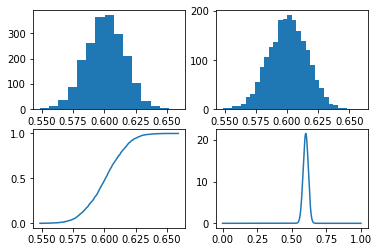

In [0]:
# Extract samples
theta = fit.extract(permuted=True)['theta']

# Print some statistics
print("Some samples:", theta[:10])
print("Mean:", np.mean(theta, axis=0))
print("Standard deviation:", np.std(theta, axis=0))

# Prepare plots
_, ax = plt.subplots(2, 2)

# histograms
# warning: for a caveat about using histograms see
# https://stats.stackexchange.com/a/51753
ax[0, 0].hist(theta, 15)
ax[0, 1].hist(theta, 30)

# Empirical cumulative distribution
ecdf = ECDF(theta)
ax[1, 0].plot(ecdf.x, ecdf.y)

# Density estimation using KDE (with tuning parameter chosen by 3 fold CV)
params_for_kde_cv = {'bandwidth': np.logspace(-2, 3, 10)}
grid = GridSearchCV(KernelDensity(), params_for_kde_cv, cv=3)
grid.fit(theta.reshape(-1, 1))
x_kde = np.linspace(0, 1, 10000).reshape(-1, 1)
y_kde = np.exp(grid.best_estimator_.score_samples(x_kde))
ax[1, 1].plot(x_kde, y_kde)

## Get MCMC samples for this model using Pyro

In [0]:
y_tensor = torch.as_tensor(y, dtype=torch.float32)

def model(y_tensor):
    prior_dist = dist.Beta(torch.Tensor([.5]), torch.Tensor([.5]))
    theta = pyro.sample('theta', prior_dist)
    with pyro.plate('observe_data'):
        pyro.sample('obs', dist.Bernoulli(theta), obs=y_tensor)

nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=500, warmup_steps=300).run(y_tensor)
posterior = mcmc_run.marginal('theta').empirical['theta']

Sample: 100%|██████████| 800/800 [00:06<00:00, 120.08it/s, step size=1.07e+00, acc. rate=0.897]


In [0]:
print("Some samples:", posterior.sample((10,)).reshape(-1))
print("Mean:", posterior.mean)
print("Standard deviation:", posterior.stddev)

Some samples: tensor([0.5688, 0.5738, 0.5995, 0.5835, 0.5992, 0.5903, 0.5898, 0.6041, 0.5919,
        0.6167])
Mean: tensor([0.5998])
Standard deviation: tensor([0.0151])


## Get replications (new instances of similar to data) from MCMC samples

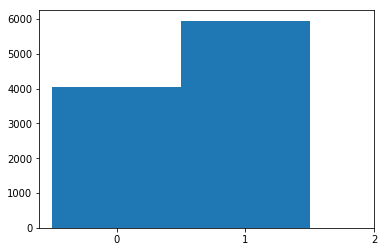

In [0]:
no_replications = 10000

posterior_samples = posterior.sample((no_replications,))
posterior_samples = posterior_samples.numpy().reshape(-1)

replications = stats.bernoulli.rvs(posterior_samples)
bins = np.arange(0, replications.max() + 1.5) - 0.5
_, ax = plt.subplots()
ax.hist(replications, bins)
ax.set_xticks(bins + 0.5)

## Get approximate Bayesian inference for Pyro and stochatisc variational inference

In [0]:
def model(y_tensor):
    prior_dist = dist.Beta(torch.Tensor([.5]), torch.Tensor([.5]))
    theta = pyro.sample('theta', prior_dist)
    with pyro.plate('observe_data'):
        pyro.sample('obs', dist.Bernoulli(theta), obs=y_tensor)

def guide(y_tensor):
    alpha = pyro.param("alpha", torch.Tensor([1.0]),
                       constraint=constraints.positive)
    beta = pyro.param("beta", torch.Tensor([1.0]),
                       constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Beta(alpha, beta))

In [0]:
# set up the optimizer
pyro.clear_param_store()
adam_params = {"lr": 0.2, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
# do gradient steps
for step in range(n_steps):
    svi.step(y_tensor)

Some samples: [0.74527141 0.51609851 0.36864775 0.58797763 0.41954004 0.59100899
 0.731861   0.52022881 0.56102338 0.64184099]
Mean: [0.55838448]
Standard deviation: [0.10022922]


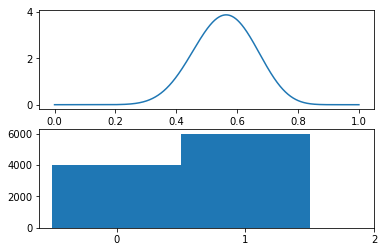

In [0]:
alpha = pyro.param("alpha")
beta = pyro.param("beta")
    
inf_distribution = stats.beta(alpha.data.numpy(), beta.data.numpy())
print("Some samples:", inf_distribution.rvs(10))
print("Mean:", inf_distribution.mean())
print("Standard deviation:", inf_distribution.std())

_, axes = plt.subplots(2)

# Plot the posterior
x_svi = np.linspace(0, 1, 10000)
y_svi = inf_distribution.pdf(x_svi)
axes[0].plot(x_svi, y_svi)

# Plot replications
posterior_samples = posterior.sample((no_replications,))
posterior_samples = posterior_samples.numpy().reshape(-1)

replications = stats.bernoulli.rvs(posterior_samples)
bins = np.arange(0, replications.max() + 1.5) - 0.5
axes[1].hist(replications, bins)
axes[1].set_xticks(bins + 0.5)

## Using GPU and data subsampling with Pyro 

In [0]:
# Setup some data for another model
mu = -0.6
sigma = 1.8

n2 = 10000
y2 = stats.norm.rvs(mu, sigma, size=n2)
y2_tensor = torch.as_tensor(y2, dtype=torch.float32).cuda()

In [0]:
def model(y2_tensor):
    # Priors:
    prior_dist_mu = dist.Normal(torch.Tensor([0.]).cuda(),
                                torch.Tensor([1.]).cuda())
    mu = pyro.sample('mu', prior_dist_mu)
    
    prior_dist_sigma = dist.Gamma(torch.Tensor([1.]).cuda(),
                                  torch.Tensor([1.]).cuda())
    sigma = pyro.sample('sigma', prior_dist_sigma)
    
    # Likelihood:
    with pyro.plate('observe_data', size=len(y2_tensor),
        subsample_size=5000, use_cuda=True) as ind:
        pyro.sample('obs', dist.Normal(mu, sigma),
            obs=y2_tensor.index_select(0, ind))
        

def guide(y2_tensor):
    alpha_mu = pyro.param("alpha_mu", torch.Tensor([0.0]).cuda())
    beta_mu = pyro.param("beta_mu", torch.Tensor([3.0]).cuda(),
        constraint=constraints.positive)
    mu = pyro.sample('mu', dist.Normal(alpha_mu, beta_mu))

    alpha_sigma = pyro.param("alpha_sigma", torch.Tensor([1.0]).cuda(),
        constraint=constraints.positive)
    beta_sigma = pyro.param("beta_sigma", torch.Tensor([1.0]).cuda(),
        constraint=constraints.positive)
    sigma = pyro.sample('sigma', dist.Gamma(alpha_sigma, beta_sigma))

In [0]:
# set up the optimizer
pyro.clear_param_store()
adam_params = {"lr": 0.2, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 10
# do gradient steps
for step in range(n_steps):
    svi.step(y2_tensor)

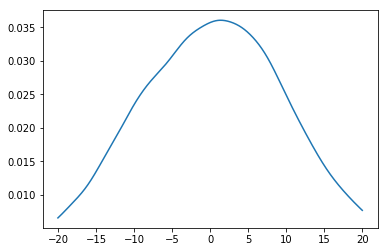

In [0]:
# Generate replications

alpha_mu = pyro.param("alpha_mu")
beta_mu = pyro.param("beta_mu")
alpha_sigma = pyro.param("alpha_sigma")
beta_sigma = pyro.param("beta_sigma")
    
mu_distribution = stats.norm(alpha_mu.item(), beta.data.item())
sigma_distribution = stats.gamma(alpha_sigma.item(), beta_sigma.item())

mu_samples = mu_distribution.rvs(no_replications)
sigma_samples = sigma_distribution.rvs(no_replications)

data_replications = stats.norm(mu_samples, sigma_samples).rvs()

# Density estimation using KDE (with tuning parameter chosen by 3 fold CV)
params_for_kde_cv = {'bandwidth': np.logspace(-2, 3, 10)}
grid = GridSearchCV(KernelDensity(), params_for_kde_cv, cv=3)
grid.fit(data_replications.reshape(-1, 1))
x_kde = np.linspace(-20, 20, 10000).reshape(-1, 1)
y_kde = np.exp(grid.best_estimator_.score_samples(x_kde))
plt.plot(x_kde, y_kde)

In [0]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, input_dim)
        self.fc22 = nn.Linear(hidden_dim, input_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        
        mu = self.fc21(hidden)
        sigma = torch.exp(self.fc22(hidden))
        return mu, sigma


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim,
        z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim=input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim=input_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            mu, sigma = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Normal(mu, sigma).to_event(1), obs=x)
            # return the loc so we can visualize it later
            #return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
      
    def new_instances(self, size=1):
         z = stats.norm.rvs(size=(size, self.z_dim))
         mu, sigma = self.decoder.forward(torch.as_tensor(z,
             device=torch.device('cuda'), dtype=torch.float32))
         return stats.norm.rvs(mu.data.cpu().numpy(), sigma.data.cpu().numpy())

## Variational autoencoders

In [0]:
# clear param store
pyro.clear_param_store()

no_instances = 20000
input_dim = 3
mu = stats.norm.rvs(size=input_dim)

# Generate a positive definite matrix
sigma = stats.norm.rvs(size=(input_dim, input_dim))
sigma[np.triu_indices(input_dim)] = 0
sigma += np.diag(np.abs(stats.norm.rvs(size=input_dim)))
sigma = np.matmul(sigma.transpose(), sigma) # inverse cholesky decomposition

dataset = stats.multivariate_normal.rvs(mu, sigma, size=no_instances)
dataset = torch.as_tensor(dataset, dtype=torch.float32)
dataset = TensorDataset(dataset)
train_loader = DataLoader(dataset, batch_size=1000, shuffle=True,
     num_workers=1, pin_memory=True, drop_last=False)

# setup the VAE
vae = VAE(use_cuda=True, input_dim=input_dim)

adam_args = {"lr": 0.001}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
for epoch in range(100):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, in train_loader:
        x = x.cuda()
        epoch_loss += svi.step(x)

    # report training diagnostics
    if not epoch % 10:
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" %
             (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 12.0625
[epoch 010]  average training loss: 5.7273
[epoch 020]  average training loss: 5.3826
[epoch 030]  average training loss: 5.3734
[epoch 040]  average training loss: 5.3898
[epoch 050]  average training loss: 5.3576
[epoch 060]  average training loss: 5.3630
[epoch 070]  average training loss: 5.3428
[epoch 080]  average training loss: 5.3604
[epoch 090]  average training loss: 5.3348


In [0]:
# Generating new instances (replications) from the trained VAE
new_instances = vae.new_instances(100000)

print("True means")
print(mu)
print("Empirical means of replications:")
print(new_instances.mean(0))

print("----------------------------------------")

print("True covariance matrix")
print(sigma)
print("Empirical covariance matrix of replications:")
print(np.cov(new_instances, rowvar=False))

True means
[ 0.96114028 -0.20429133 -0.83652706]
Empirical means of replications:
[ 0.96612779 -0.23635043 -0.91886219]
----------------------------------------
True covariance matrix
[[ 4.74371511 -2.46075695 -1.97981744]
 [-2.46075695  2.67486053  1.06406042]
 [-1.97981744  1.06406042  1.70799343]]
Empirical covariance matrix of replications:
[[ 4.73416853 -2.35541449 -1.90316439]
 [-2.35541449  2.74554436  1.07713679]
 [-1.90316439  1.07713679  1.70246573]]
